Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3084, 12, 6, 195, 2, 3136, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [96]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (1, 1)]:
    data_index = 0
    batch_size = 16
    batch, labels = generate_batch(batch_size=batch_size, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(batch_size)])
    print(batch.shape, labels.shape)

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term', 'of', 'of', 'abuse', 'abuse', 'first', 'first', 'used', 'used']
    labels: ['anarchism', 'as', 'originated', 'a', 'term', 'as', 'a', 'of', 'abuse', 'term', 'of', 'first', 'used', 'abuse', 'against', 'first']
(16,) (16, 1)

with num_skips = 1 and skip_window = 1:
    batch: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers']
    labels: ['anarchism', 'a', 'term', 'a', 'abuse', 'of', 'abuse', 'against', 'used', 'working', 'class', 'working', 'class', 'radicals', 'including', 'of']
(16,) (16, 1)


Train a skip-gram model.

In [17]:
def generate_batch_cbow(batch_size, skip_window):
  global data_index
  assert data_index >= skip_window
  batch = np.ndarray(shape=(batch_size, 2 * skip_window), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

  for j in range(batch_size):
    for i in range(skip_window):
      batch[j, 2 * i] = data[data_index - (i + 1)]
      batch[j, 2 * i + 1] = data[data_index + i + 1]
    labels[j, 0] = data[data_index]
    data_index = (data_index + 1) % (len(data) - skip_window)

  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

skip_window = 2
data_index = 2
batch_size = 16
batch, labels = generate_batch_cbow(batch_size=batch_size, skip_window=skip_window)
print('\nwith skip_window = %d:' % (skip_window))
print('    labels:', [reverse_dictionary[li] for li in labels.reshape(batch_size)])
print('    batch:', [[reverse_dictionary[bi] for bi in batch[row,:]] for row in range(batch_size)])


data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with skip_window = 2:
    labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of']
    batch: [['originated', 'a', 'anarchism', 'term'], ['as', 'term', 'originated', 'of'], ['a', 'of', 'as', 'abuse'], ['term', 'abuse', 'a', 'first'], ['of', 'first', 'term', 'used'], ['abuse', 'used', 'of', 'against'], ['first', 'against', 'abuse', 'early'], ['used', 'early', 'first', 'working'], ['against', 'working', 'used', 'class'], ['early', 'class', 'against', 'radicals'], ['working', 'radicals', 'early', 'including'], ['class', 'including', 'working', 'the'], ['radicals', 'the', 'class', 'diggers'], ['including', 'diggers', 'radicals', 'of'], ['the', 'of', 'including', 'the'], ['diggers', 'the', 'the', 'english']]


In [127]:
def generate_batch_predict_next(batch_size):
  global data_index
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

  for j in range(batch_size):
    batch[j] = data[data_index]
    labels[j, 0] = data[data_index + 1]
    data_index = (data_index + 1) % (len(data) - 1)

  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

data_index = 0
batch_size = 16
batch, labels = generate_batch_predict_next(batch_size=batch_size)
print('    labels:', [reverse_dictionary[li] for li in labels.reshape(batch_size)])
print('    batch:', [reverse_dictionary[bi] for bi in batch.reshape(batch_size)])
print(batch.shape, labels.shape)

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']
    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers']
    batch: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the']
(16,) (16, 1)


In [139]:

batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

  input = tf.placeholder(tf.int32, shape=[1])
  input_embed = tf.nn.embedding_lookup(embeddings, input)
  res = tf.matmul(softmax_weights, tf.transpose(input_embed))
  res = tf.reshape(res, [vocabulary_size]) + softmax_biases
  prediction = tf.argmax(res)
  k = 5
  logits, predictions = tf.nn.top_k(res, k=k)


In [129]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  saver = tf.train.Saver()
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch_predict_next(batch_size)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()
  final_embeddings_not_norm = embeddings.eval()
  final_weights = softmax_weights.eval()
  final_biases = softmax_biases.eval()
    
  save_path = saver.save(session, "saved_models/skipgram_model.ckpt")
  print("Model saved in path: %s" % save_path)

    

Initialized
Average loss at step 0: 7.444205
Nearest to war: deceiving, cronos, essayist, discursive, keenan, appellate, letter, layered,
Nearest to about: confusing, incomes, onto, rallies, depths, awk, griffey, widget,
Nearest to use: birds, hinterland, behaving, junior, roch, busts, errant, sprouted,
Nearest to be: slovakia, carriages, pcr, ministers, insurmountable, smugglers, iib, kabbalah,
Nearest to on: gast, mmol, naturalis, rna, arleigh, onyx, hyperfine, pretensions,
Nearest to were: previews, geologically, reinforces, connectivity, giscard, italiano, tested, gomes,
Nearest to see: smells, casper, titus, overviews, candida, speculated, girlfriend, players,
Nearest to state: masks, obstacle, krugerrand, jurisdiction, larch, barking, ev, serpento,
Nearest to no: cheung, gallagher, feistel, castration, airing, kayak, forgiving, excavations,
Nearest to people: offshoots, mishnayot, maiden, landmark, westeros, committing, refounded, separators,
Nearest to that: recantation, orderly

Average loss at step 52000: 3.085289
Average loss at step 54000: 3.106268
Average loss at step 56000: 3.116715
Average loss at step 58000: 3.001978
Average loss at step 60000: 3.073253
Nearest to war: amalgamation, ii, bishops, transvaal, oncology, bantu, love, protists,
Nearest to about: around, of, than, replace, over, after, between, from,
Nearest to use: because, made, end, using, boac, destruction, win, both,
Nearest to be: being, been, is, was, are, were, usually, often,
Nearest to on: through, of, in, retrieved, prespa, during, from, against,
Nearest to were: was, been, are, being, be, is, had, have,
Nearest to see: grooming, runoff, asmara, confessed, surpassed, adas, mont, rutles,
Nearest to state: government, mcc, burckhardt, hom, junta, overheard, national, krugerrand,
Nearest to no: any, little, dis, aegon, dup, amide, krieg, sandwich,
Nearest to people: children, women, men, others, jews, person, persons, howell,
Nearest to that: which, what, but, where, however, this, sim

In [33]:
############################### SKIPGRAM

import random

w = 'food'

for _ in range(10):

    print(w)

    my_dataset = [dictionary[w]]

    #with tf.Session(graph=graph) as session:
    with tf.Session(graph=graph).as_default():

        embed = tf.nn.embedding_lookup(final_embeddings_not_norm, my_dataset)
#        print(embed.shape, final_weights.shape, final_biases.shape)
        res = tf.matmul(final_weights, tf.transpose(embed))
#        print(res.shape)
        res = tf.reshape(res, [vocabulary_size]) + final_biases
#        print(res.shape)
        #out = tf.argmax(res).eval()
        res = res.eval()
        k = 5
        vals, inds = tf.nn.top_k(res, k=k)
        print(vals, inds)
        out = inds[random.randint(0, k - 1)]
#        print(reverse_dictionary[out])
        w = reverse_dictionary[out]

#from six.moves import cPickle as pickle
#with open('skipgram.pickle', 'wb') as f:
#    my_object = {'dictionary': dictionary,
#                 'reverse_dictionary': reverse_dictionary,
#                 'embeddings': final_embeddings_not_norm,
#                 'weights': final_weights,
#                 'biases': final_biases}
#    pickle.dump(my_object, f, protocol=2)

food


ValueError: Cannot use the default session to evaluate tensor: the tensor's graph is different from the session's graph. Pass an explicit session to `eval(session=sess)`.

In [170]:

print(final_biases[0], final_weights[0][0], final_embeddings_not_norm[0][0])

import random

skip_list = [dictionary[w] for w in ['UNK', 'one']]

with tf.Session(graph=graph) as session:
    saver = tf.train.Saver()
    saver.restore(session, "saved_models/skipgram_model.ckpt")
    print("Model restored.")

    out = dictionary['hello']
#    out = random.randint(0, len(dictionary) - 1)
#    out = random.randint(0, 1000)

    print(reverse_dictionary[out])
    
    used = []
    for _ in range(100):
        used.append(out)
        my_dataset = [out]
        feed_dict = {input : my_dataset}

        out = session.run(predictions, feed_dict=feed_dict)
#        print([reverse_dictionary[u] for u in out])
        out = [o for o in out if o not in used and o not in skip_list and (len(reverse_dictionary[o]) > 1 or o == 'a' or o == 'i')]
        if len(out) <= 0:
            break
        out = out[random.randint(0, len(out) - 1)]
#        out = out[0]
#        out = out[-1]
#        print(reverse_dictionary[out])
        
print(" ".join([reverse_dictionary[u] for u in used]))
#print(" ".join([reverse_dictionary[u] for u in reversed(used)]))

#from six.moves import cPickle as pickle
#with open('predict_next.pickle', 'wb') as f:
#    my_object = {'dictionary': dictionary,
#                 'reverse_dictionary': reverse_dictionary,
#                 'embeddings': final_embeddings_not_norm,
#                 'weights': final_weights,
#                 'biases': final_biases}
#    pickle.dump(my_object, f, protocol=2)


9.229091 -0.038162082 0.12637208
INFO:tensorflow:Restoring parameters from saved_models/skipgram_model.ckpt
Model restored.
hello
e 9.873848
6423
[71  0  4  1 75]
e 9.172648
1
[  86    0 1071   46    4]
e 9.374884
1071
[ 810  792 2812    0 1724]
e 9.33047
2812
[  73   75    4 1724    3]
e 10.038423
1724
[ 731 7056 1724   64    0]
e 9.1486635
731
[ 723 2185 3770 1999 2777]
e 8.649414
723
[   4  414    5 1724    3]
e 8.69668
3
[   1   30 1123    0    6]
e 8.3956
30
[ 409  730  785  140 1031]
e 9.980081
1031
[2 0 3 5 1]
e 9.70026
5
[   4    1 4697   30    6]
e 9.113004
4697
[  11    4  673 4697    1]
e 7.2707014
673
[ 28   4 137   5   2]
e 8.525098
137
[  2   5 515   4   1]
e 9.231655
2
[4697    1   30  316    6]
e 8.750565
316
[ 4 73 75  3  5]
hello the nobel laureate jackson county california and his brother in jamaica independence day of england


In [137]:

################ CBOW #############

batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size, 2 * skip_window])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  averaged = tf.reduce_mean(embed, axis=1)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=averaged,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [32]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch_cbow(batch_size, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()
  final_embeddings_not_norm = embeddings.eval()
  final_weights = softmax_weights.eval()
  final_biases = softmax_biases.eval()


Initialized
Average loss at step 0: 7.915423
Nearest to these: knowles, misdemeanors, desperation, wicca, ct, dubs, bratislava, emigrant,
Nearest to two: genomic, signer, suez, luoyang, relativity, alans, louis, bitterly,
Nearest to history: befriends, clifford, aronson, lecter, fetus, posner, jasper, ensures,
Nearest to their: ost, bechtel, tenses, lodge, quasi, quo, austrian, suda,
Nearest to while: luiz, leclerc, tractable, boxcar, donne, austin, january, suffices,
Nearest to s: grits, chrysotile, method, citizen, tamara, antipodes, wiecino, digimon,
Nearest to but: argument, heaney, mellor, conjectures, acf, triplet, foreshadowed, conceivable,
Nearest to which: ippon, wittelsbach, equivalents, passer, leveraged, impressionists, classical, ventral,
Nearest to his: limited, swat, ios, parks, transcendence, takeshi, deism, btr,
Nearest to many: nizam, disappearances, hobart, dressed, commemorates, charcot, dropping, biographical,
Nearest to they: sibylla, report, hesperides, pictures,

Average loss at step 52000: 2.797526
Average loss at step 54000: 2.823774
Average loss at step 56000: 2.855936
Average loss at step 58000: 2.831830
Average loss at step 60000: 2.844104
Nearest to these: such, those, some, various, several, many, successive, both,
Nearest to two: three, six, four, one, five, seven, eight, nine,
Nearest to history: barges, vail, smashed, philosophical, period, vcs, thoroughbred, playboys,
Nearest to their: its, his, her, your, our, the, my, allocation,
Nearest to while: when, although, after, metro, before, airstrip, and, including,
Nearest to s: isbn, whose, elphinstone, his, nagpur, recreational, maharashtri, overarching,
Nearest to but: however, although, and, though, initially, iucn, gua, see,
Nearest to which: that, this, what, also, minimizing, bigotry, mondegreens, these,
Nearest to his: her, their, its, my, your, our, whose, the,
Nearest to many: some, several, various, those, most, both, these, few,
Nearest to they: we, he, you, she, there, it, 

In [51]:

def get_input(words):
    w = words.split()
    assert len(w) == 4
    return [dictionary[word] for word in w]

print(dictionary['but'])
print(reverse_dictionary[42])

my_dataset = [42]

print(final_embeddings[:3, :3])

with tf.Session(graph=graph) as session:

    norm = tf.sqrt(tf.reduce_sum(tf.square(final_embeddings), 1, keep_dims=True))
    normalized_embeddings = final_embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, my_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))
    
    sim = similarity.eval()

    print(sim[0, :10])
    
    top_k = 8 # number of nearest neighbors
    nearest = (-sim[0, :]).argsort()[1:top_k+1]
    for k in range(top_k):
        close_word = reverse_dictionary[nearest[k]]
        print(close_word)
        
    print(softmax_biases.shape)
    o = tf.matmul(softmax_weights, tf.transpose(valid_embeddings))[:,0] + softmax_biases
    print(o.shape)
    print(tf.argmax(o))
    
    #######################
    
    context_words = [get_input("one two three four")]
    embed = tf.nn.embedding_lookup(final_embeddings_not_norm, context_words)
    averaged = tf.reduce_mean(embed, axis=1)
    print(len(context_words), embed.shape, averaged.shape, final_weights.shape, final_biases.shape)
    res = tf.matmul(final_weights, tf.transpose(averaged))
    print(res.shape)
    res = tf.reshape(res, [vocabulary_size]) + final_biases
    print(res.shape)
    out = tf.argmax(res).eval()
    print(reverse_dictionary[out])

        
#from six.moves import cPickle as pickle
#with open('dic_revdic_embed.pickle', 'wb') as f:
#    my_object = {'dictionary': dictionary, 'reverse_dictionary': reverse_dictionary, 'embeddings': final_embeddings}
#    pickle.dump(my_object, f, protocol=2)

#from six.moves import cPickle as pickle
#with open('dic_revdic_embed_weight_bias.pickle', 'wb') as f:
#    my_object = {'dictionary': dictionary,
#                 'reverse_dictionary': reverse_dictionary,
#                 'embeddings': final_embeddings_not_norm,
#                 'weights': final_weights,
#                 'biases': final_biases}
#    pickle.dump(my_object, f, protocol=2)

42
but
[[ 0.16524537 -0.05223871  0.10509466]
 [ 0.09509375 -0.03081938 -0.13225202]
 [-0.14550745  0.10343006 -0.06203036]]
[-0.08871263 -0.03328216  0.0963823   0.43377823  0.00366534  0.14773172
  0.0071833   0.06426408  0.0177195  -0.05438087]
however
although
though
and
see
soared
which
initially
(50000,)
(50000,)
Tensor("ArgMax_30:0", shape=(), dtype=int64)
1 (1, 4, 128) (1, 128) (50000, 128) (50000,)
(50000, 1)
(50000,)
zero


In [10]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

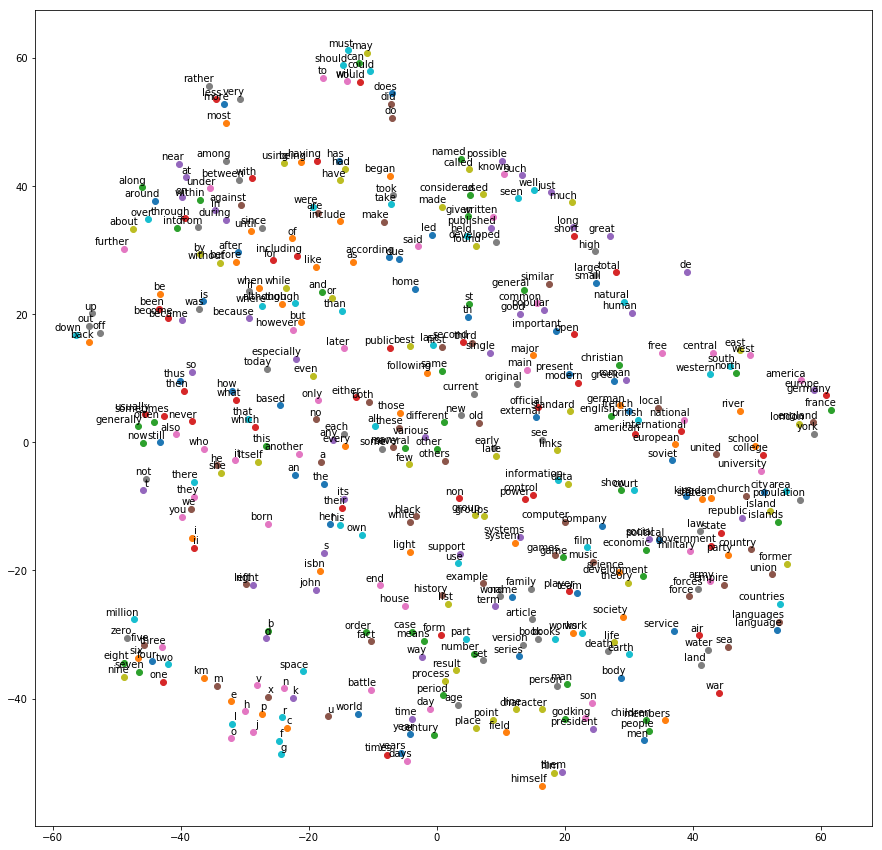

In [11]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---